# Analyse SA results

Extract w Sobol indices from Dakota's summary.out file and plot.

In [64]:
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt

Run with `dakota -i sa_lt.in > sa_summary.out`: only `>` gets results written to file.

In [65]:
# Must be am easier way to get Dakota results out? Apparently not
# Read in .out file (contains summary results)
output_files = ["sa_lt_summary.out", "sa_lt_max_q_summary.out"]

# Match line in output
# w results section
w_results_re = re.compile(
    r"w Sobol' indices:\n\s+Main\s+Total\n((\s+(?:-?\d\.?\d*e[+-]\d+)\s+(?:-?\d\.?\d*e[+-]\d+)\s+(?:\w+)\n)+)"
)
# Line of Sobol indices data
sobols_line_re = re.compile(r"\s+(-?\d\.?\d*e[+-]\d+)\s+(-?\d\.?\d*e[+-]\d+)\s+(\w+)")
results = {
    "design": [],
    "descriptor": [],
    "latex_descriptor": [],
    "main": [],
    "total": [],
}

param_latex = {
    "fdene": r"$f^{max}_{GW}$",
    "hfact": r"$H_{98, y2}$",
    "coreradius": r"$\rho_{core}$",
    "ralpne": r"$f_{imp, He}$",
    "fimp_14": r"$f_{imp, W}$",
    "psepbqarmax": r"$\frac{P_{sep}B_T}{qAR_0}^{max}$",
    "flhthresh": r"$f^{min}_{LH}$",
    "cboot": r"$c_{BS}$",
    "peakfactrad": r"$\tau^{max}_{rad}$",
    "kappa": r"$\kappa_{sep}$",
    "etaech": r"$n_{ECRH}$",
    "feffcd": r"$f_{CD}$",
    "etath": r"$\eta_{th}$",
    "etaiso": r"$\eta_{iso}$",
    "boundl_18": r"$q^{min}_{95}$",
    "pinjalw": r"$P^{max}_{inj}$",
    "alstroh": r"$\sigma^{max}_{CS}$",
    "sig_tf_wp_max": r"$\simga^{max}_{TF}$",
    "aspect": r"$A$",
    "boundu_2": r"$B^{max}_{T}$",
    "triang": r"$\delta_{sep}$",
    "higher_order": "$S_{higher}$",
}

# Find the first set of summary results, which are for w
# Subsequent summary results correspond to individual constraints
for output_file in output_files:
    design_and_suffix = output_file.split("sa_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        # Read entire file
        content = f.read()

    # Find w results
    matches = w_results_re.search(content)
    sobols_str = matches.group(1)
    sobols_str = sobols_str.removesuffix("\n")
    for line in sobols_str.split("\n"):
        line_matches = sobols_line_re.match(line)
        results["design"].append(design)
        results["descriptor"].append(line_matches.group(3))
        results["main"].append(float(line_matches[1]))
        results["total"].append(float(line_matches[2]))
        results["latex_descriptor"].append(param_latex[line_matches.group(3)])

# Calculate higher Sobol indices
results["higher"] = []
for i in range(len(results["main"])):
    results["higher"].append(results["total"][i] - results["main"][i])

sobols_df = pd.DataFrame(results)
sobols_df

,design,descriptor,latex_descriptor,main,total,higher
0,lt,fimp_14,"$f_{imp, W}$",2.366588e-01,8.487090e-01,6.120502e-01
1,lt,ralpne,"$f_{imp, He}$",9.382534e-02,8.172790e-01,7.234536e-01
2,lt,kappa,$\kappa_{sep}$,2.017109e-03,9.479393e-02,9.277683e-02
3,lt,flhthresh,$f^{min}_{LH}$,9.077195e-03,5.160774e-03,-3.916420e-03
4,lt,triang,$\delta_{sep}$,1.612433e-03,6.785843e-02,6.624600e-02
5,lt,cboot,$c_{BS}$,3.096629e-02,2.929753e-01,2.620091e-01
6,lt,pinjalw,$P^{max}_{inj}$,-2.855401e-07,1.829429e-11,2.855584e-07
7,lt,etath,$\eta_{th}$,-6.451329e-09,7.706552e-13,6.452100e-09
8,lt_max_q,fimp_14,"$f_{imp, W}$",3.992254e-01,8.624416e-01,4.632162e-01
9,lt_max_q,ralpne,"$f_{imp, He}$",8.492775e-02,5.339404e-01,4.490126e-01


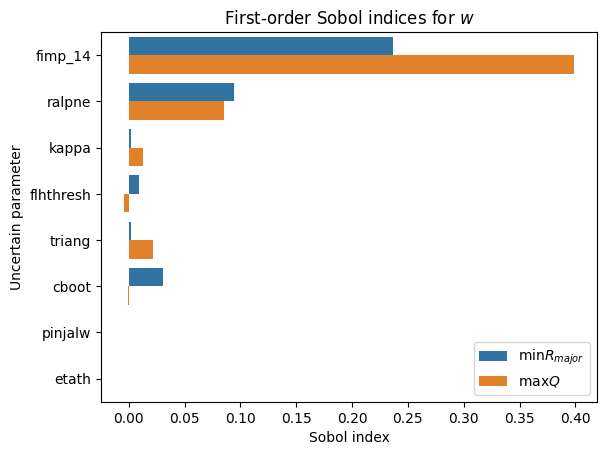

In [66]:
# Plot first orders for both designs
# Plotting single column: no need to melt
ax = sns.barplot(
    data=sobols_df,
    x="main",
    y="descriptor",
    hue="design",
    orient="h",
)
ax.set_title("First-order Sobol indices for $w$")
ax.set_xlabel("Sobol index")
ax.set_ylabel("Uncertain parameter")
label_map = {"lt": "$\min R_{major}$", "lt_max_q": "$\max Q$"}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [label_map[l] for l in labels])

# Latex for uncertain params
# TODO Raises warning
# old_y_label_objs = [y_label_obj for y_label_obj in ax.get_yticklabels()]
# new_y_labels = []
# for old_y_label_obj in old_y_label_objs:
#     old_text = old_y_label_obj.get_text()
#     new_text = param_latex[old_text]
#     new_y_labels.append(new_text)

# ax.set_yticklabels(new_y_labels)

In [67]:
# Plot first and higher orders for both designs
# Need to plot multiple columns of data: melt
sobols_melted_df = sobols_df.melt(id_vars=["design", "descriptor", "latex_descriptor"])
# Only interested in main (first order) and higher order cols
sob_melt_mh_df = sobols_melted_df[sobols_melted_df["variable"].isin(["main", "higher"])]
sob_melt_mh_df

,design,descriptor,latex_descriptor,variable,value
0,lt,fimp_14,"$f_{imp, W}$",main,2.366588e-01
1,lt,ralpne,"$f_{imp, He}$",main,9.382534e-02
2,lt,kappa,$\kappa_{sep}$,main,2.017109e-03
3,lt,flhthresh,$f^{min}_{LH}$,main,9.077195e-03
4,lt,triang,$\delta_{sep}$,main,1.612433e-03
5,lt,cboot,$c_{BS}$,main,3.096629e-02
6,lt,pinjalw,$P^{max}_{inj}$,main,-2.855401e-07
7,lt,etath,$\eta_{th}$,main,-6.451329e-09
8,lt_max_q,fimp_14,"$f_{imp, W}$",main,3.992254e-01
9,lt_max_q,ralpne,"$f_{imp, He}$",main,8.492775e-02


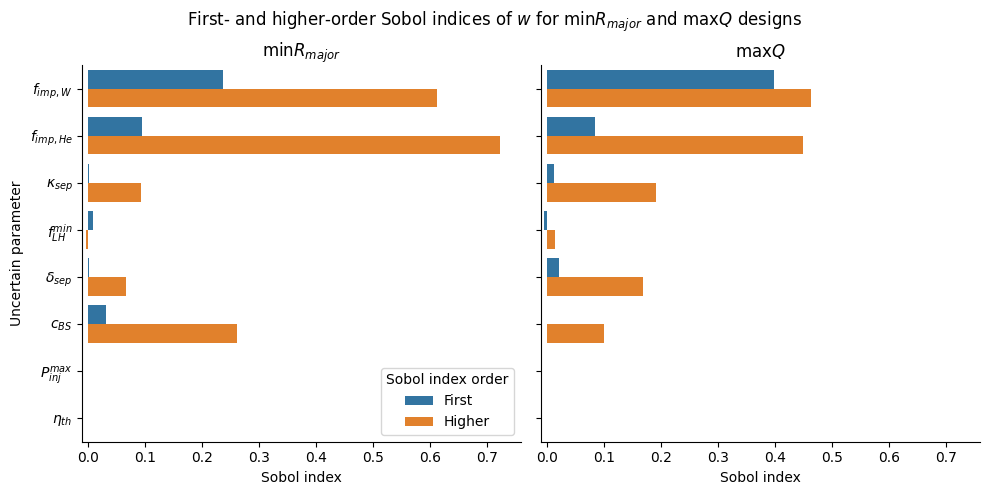

In [68]:
# Plot everything: both designs, first and higher Sobols, all unc params
fg = sns.catplot(
    data=sob_melt_mh_df,
    x="value",
    y="latex_descriptor",
    # y="descriptor",
    hue="variable",
    kind="bar",
    col="design",
    orient="h",
    legend_out=False,
)
# Move plots down slights to make room for suptitle
fg.figure.subplots_adjust(top=0.87)
fg.figure.suptitle(
    "First- and higher-order Sobol indices of $w$ for $\min R_{major}$ and $\max Q$ designs"
)
fg.set_axis_labels("Sobol index", "Uncertain parameter")
design_map = {"lt": "$\min R_{major}$", "lt_max_q": "$\max Q$"}
fg.set_titles("{col_name}")
for ax in fg.axes.flatten():
    ax.set_title(design_map[ax.get_title()])
    ax.set_xlim(-0.01)


legend_map = {"main": "First", "higher": "Higher"}
fg.add_legend(loc="lower right")
fg.legend.set_title("Sobol index order")
for legend_text in fg.legend.get_texts():
    legend_text.set_text(legend_map[legend_text.get_text()])

plt.savefig("sobols.pdf", bbox_inches="tight")